Days until 100k: 103.11433751966501


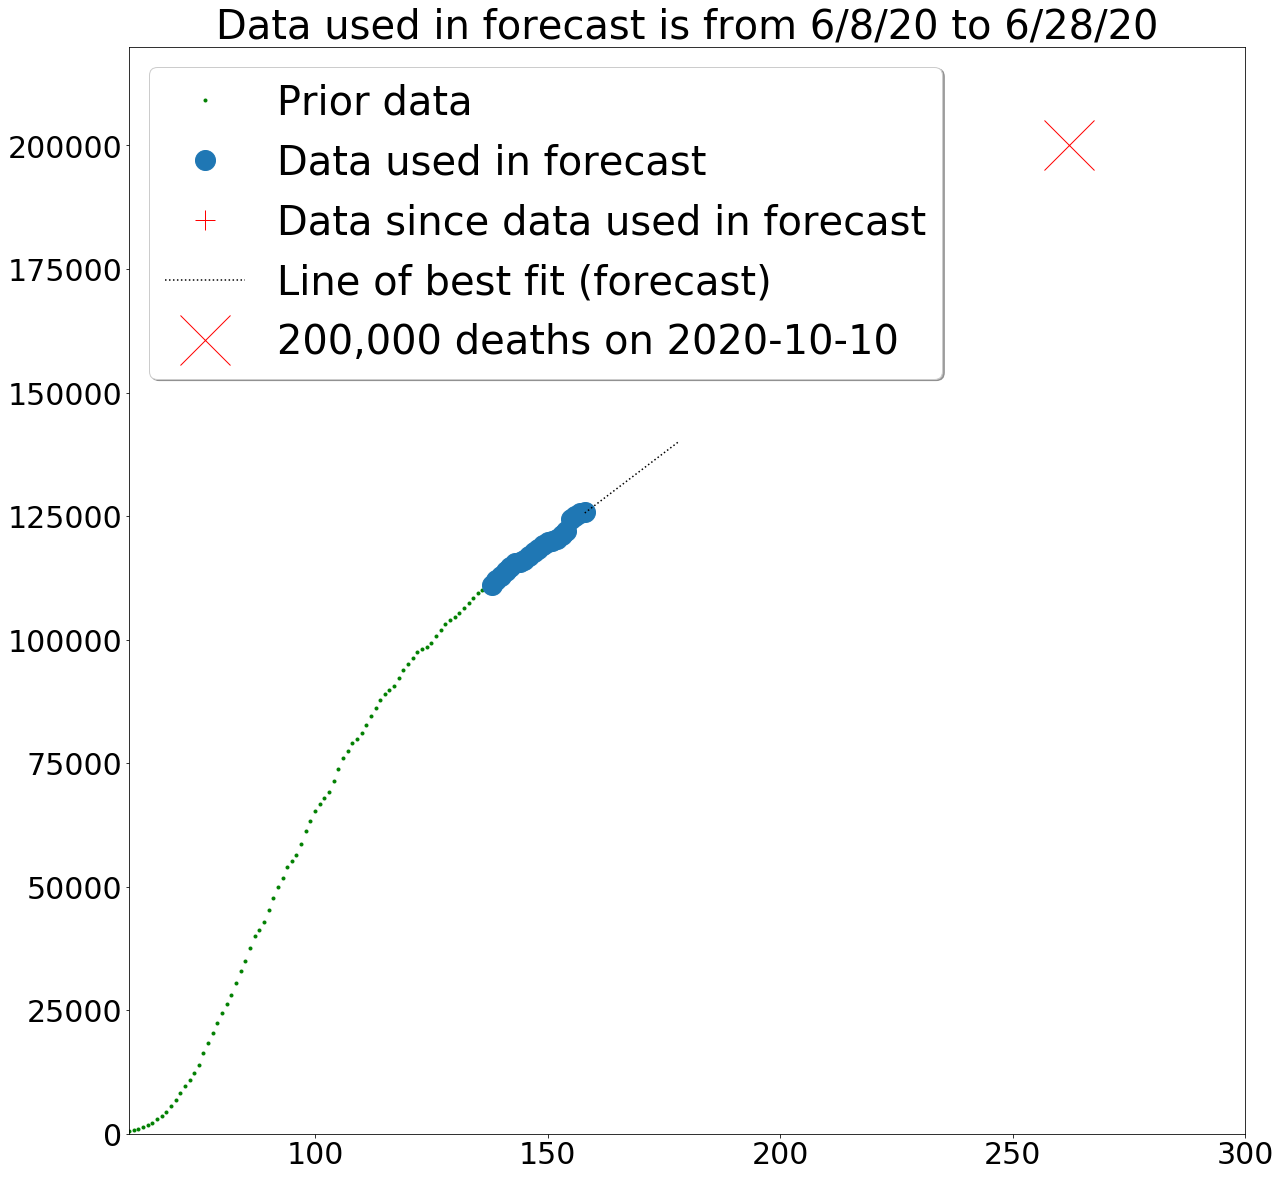

<Figure size 432x288 with 0 Axes>

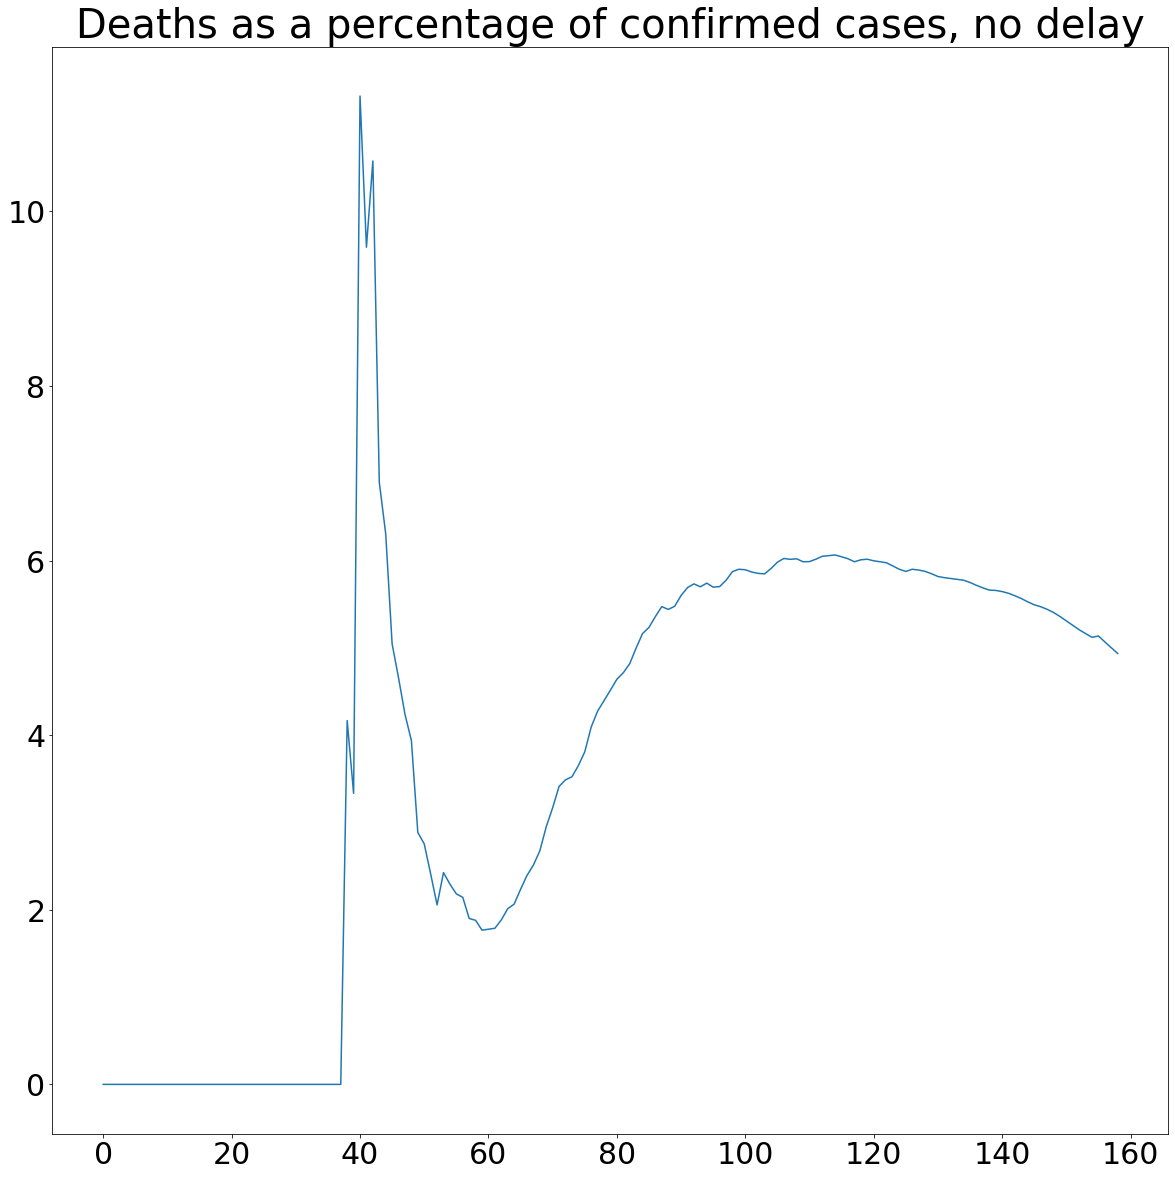

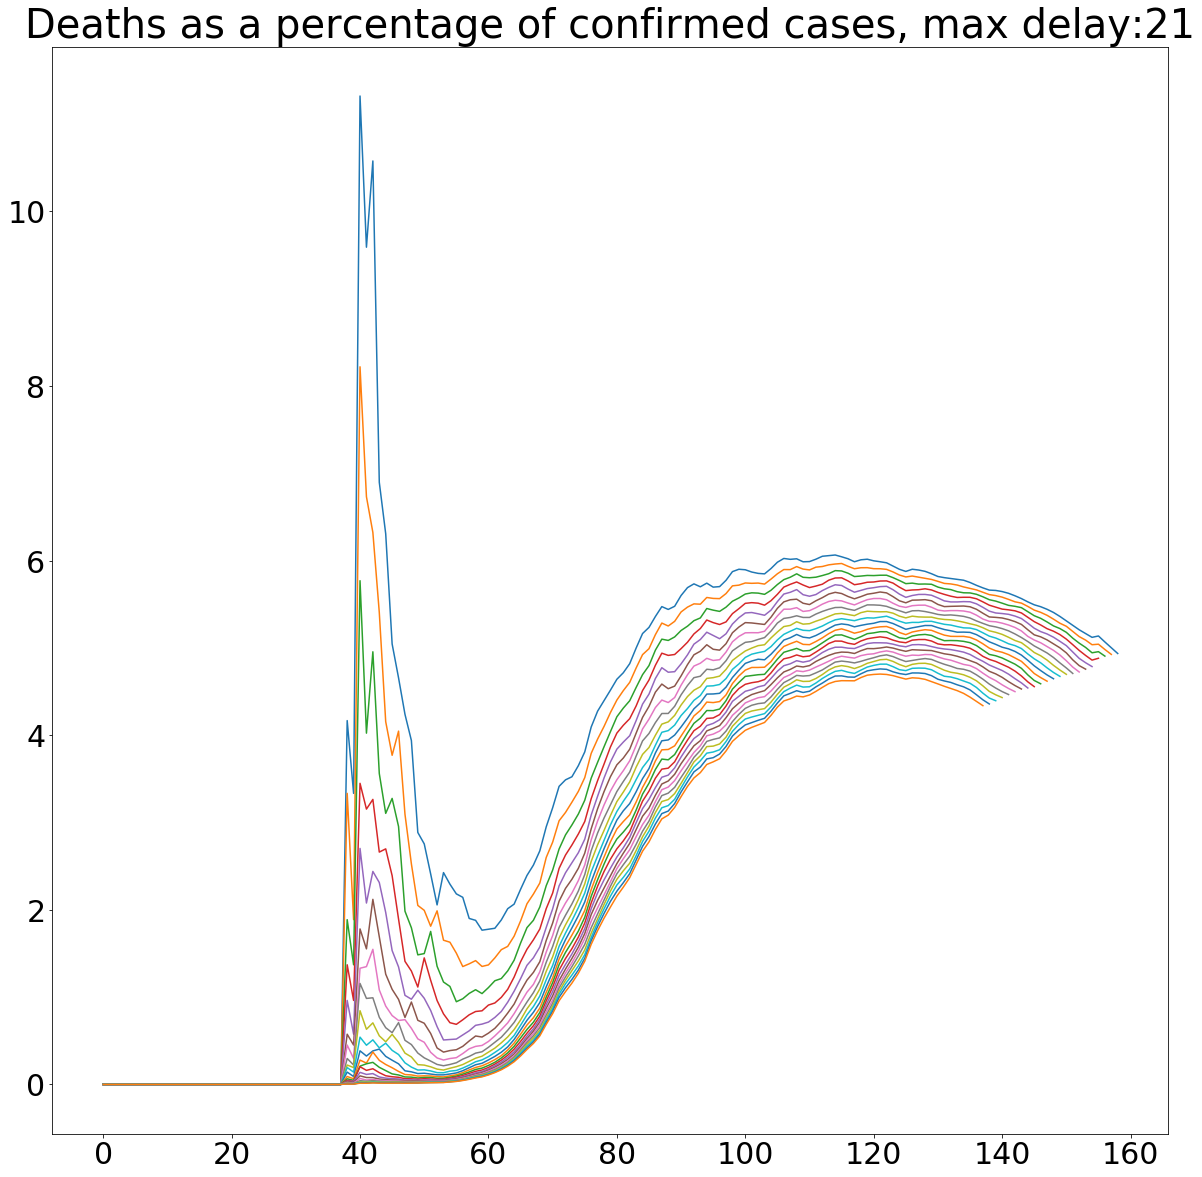

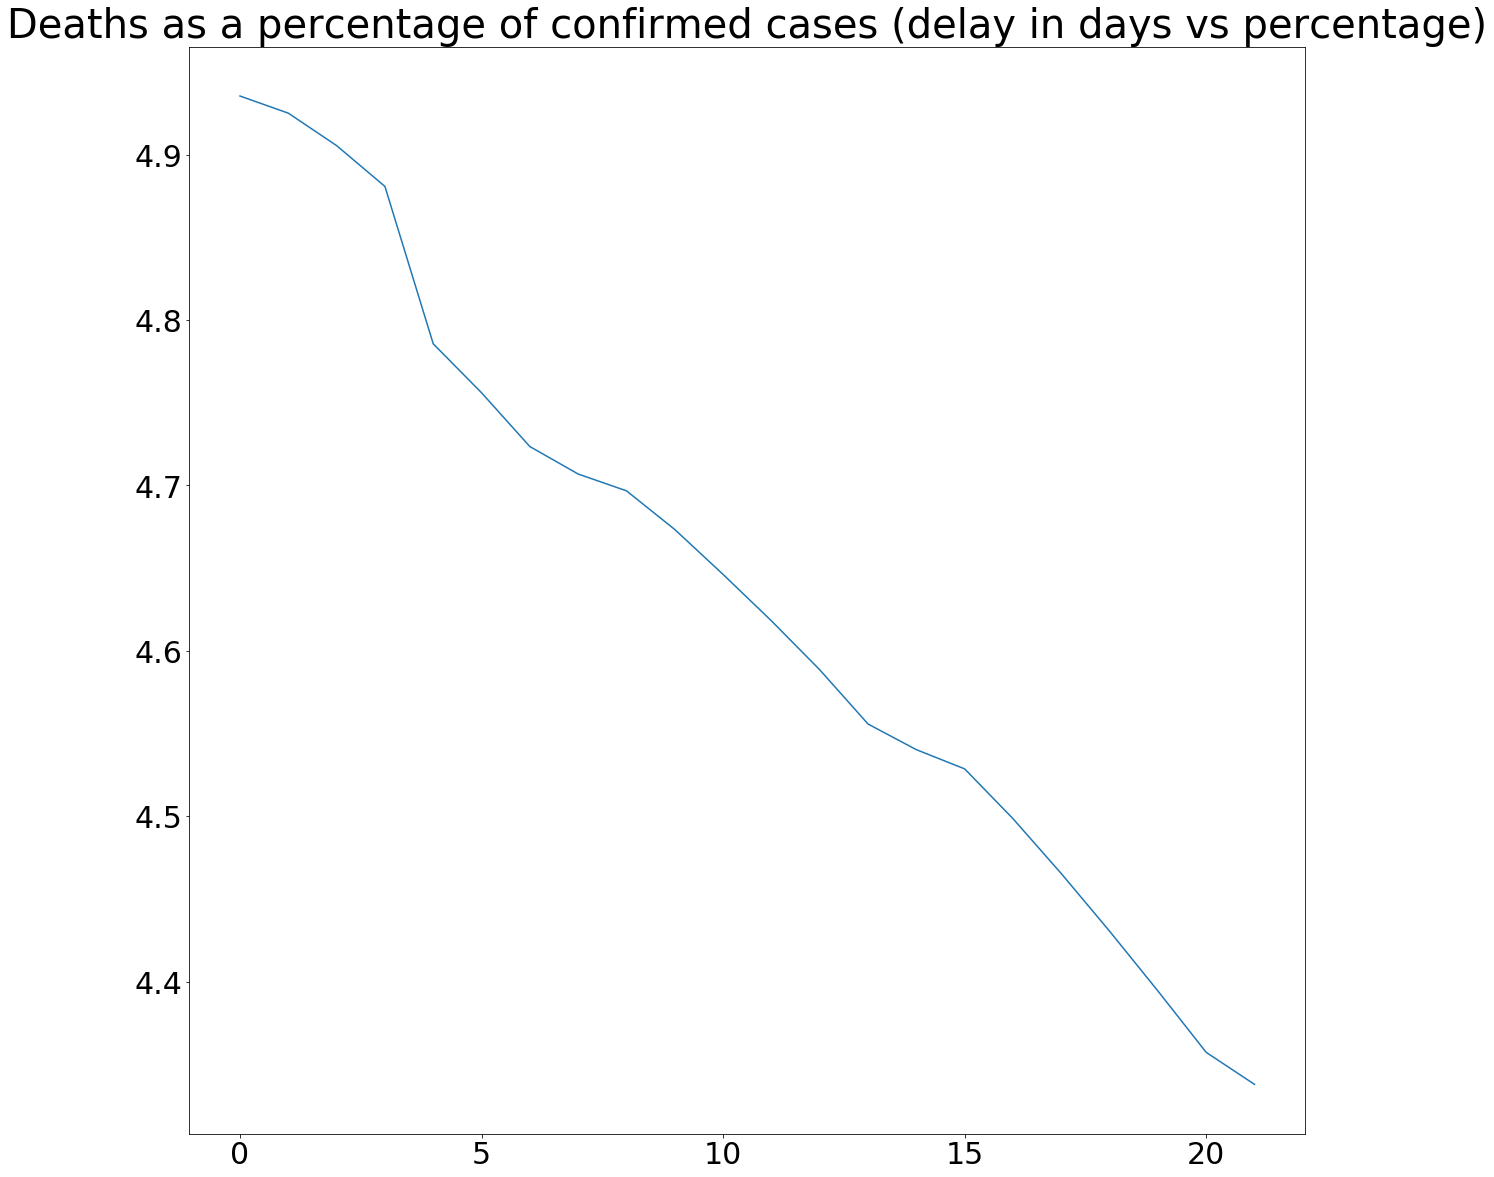

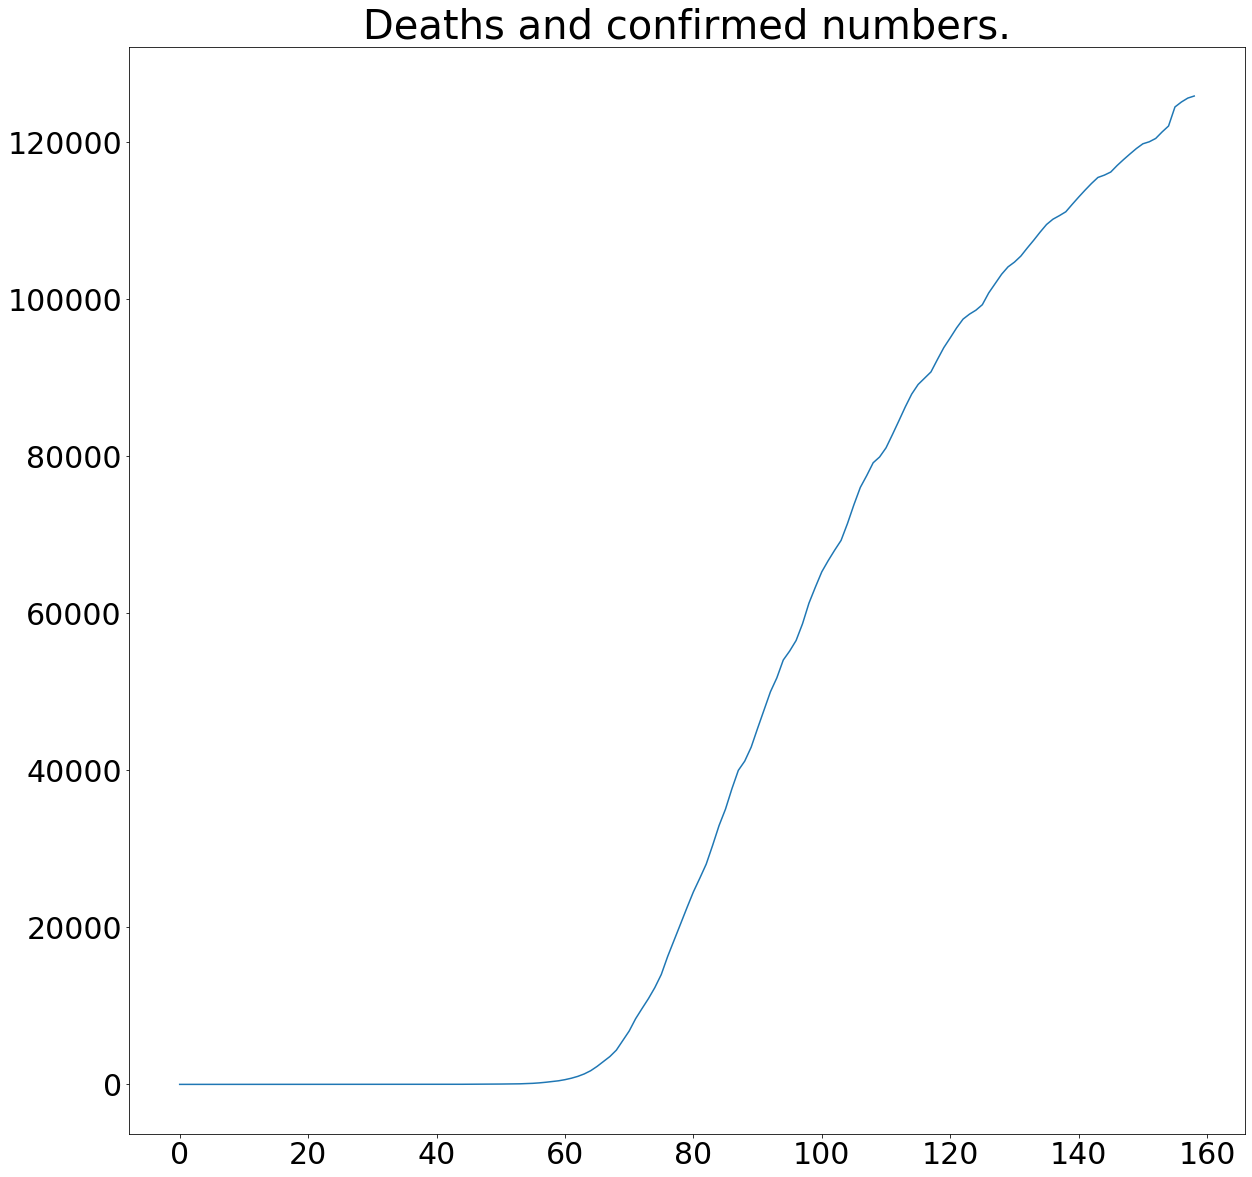

In [38]:
from numpy import log10, asarray, polyfit, ceil, arange
import csv
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json
import os.path
from os import path

def read_covid_data(data_type):
    if (data_type in ['confirmed', 'deaths', 'recovered']):
        COVID_directory = "/Users/kootsoop/git/COVID-19/csse_covid_19_data/csse_covid_19_time_series/"
        first_row = None
        with open(COVID_directory + 'time_series_covid19_' + data_type + '_global.csv') as csvfile:
            confirmed = csv.reader(csvfile)
            for row in confirmed:
                if (first_row == None):
                    first_row = row
                if (row[1] == 'US'):
                    us_data = row
                    break
    else:
        raise Exception('Invalid data_type', data_type)
    return(first_row, us_data)

FORECAST_FILE = 'forecasts200k.txt'
if (path.exists(FORECAST_FILE)):
    forecast_file = open(FORECAST_FILE, 'r')
    forecasts200k = json.load(forecast_file)
    forecast_file.close()
else:
    forecasts200k = {}

(first_row, confirmed) = read_covid_data('confirmed')
(first_row2, recovered) = read_covid_data('recovered')
(first_row3, deaths) = read_covid_data('deaths')

# print(first_row[4:(len(first_row)-1)])
# print(deaths)
# print(str(len(first_row)) + ' ' \
#       +  str(len(confirmed))+ ' ' +  str(len(first_row2))+ ' ' +  str(len(recovered))+ ' ' \
#       +  str(len(first_row3))+ ' ' +  str(len(deaths)))

death_data = [(float(data)) for data in deaths[4:(len(first_row))]]
recovered_data = [(float(data)) for data in recovered[4:(len(first_row))]]
confirmed_data = [(float(data)) for data in confirmed[4:(len(first_row))]]

first_row_shifted = [ data for data in first_row[4:(len(first_row))]]
x_axis = arange(len(death_data))

# Started at 70 @ 2020/5/10
# 133 2020/06/24
# 137 2020/06/28
start_fit = 138
# Started 20 more than start_fit
end_fit = start_fit + 20
y_fit_data = death_data[start_fit:end_fit+1]
x_fit_data = arange(start_fit,end_fit+1)

y_pre = death_data[1:start_fit]
x_pre = arange(1,start_fit)


y_new_data = death_data[end_fit+1:len(death_data)]
x_new_data = arange(end_fit+1, len(death_data))

x_forecast = arange(end_fit, len(death_data) + 20)

[m, b] = polyfit(x_fit_data, y_fit_data, 1)

day_for_100k = (200000-b)/m


days_until = day_for_100k - len(first_row_shifted) 

print('Days until 100k: ' + str(day_for_100k - len(first_row_shifted) ))

plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=8)


date_for_200k = (datetime.now() + timedelta(days=days_until)).date()

if (not first_row_shifted[end_fit] in forecasts200k):
    forecasts200k.update({ first_row_shifted[end_fit] : str(date_for_200k) })
    forecast_file = open(FORECAST_FILE, 'w+')
    json.dump(forecasts200k, forecast_file)
    forecast_file.close()

plt.figure(1)
plt.plot(x_pre, y_pre, 'g.', label='Prior data')
plt.plot(x_fit_data, y_fit_data,'o', markersize=20, label='Data used in forecast')
plt.plot(x_new_data, y_new_data,'r+',markersize=20,  label='Data since data used in forecast')
plt.plot(x_forecast, m*x_forecast + b,'k:',markersize=14,  label='Line of best fit (forecast)')
plt.plot(day_for_100k, 200000, 'rx', markersize=50, label='200,000 deaths on ' + str(date_for_200k))
plt.ylim(0,220000)
plt.xlim(60,300)
plt.title('Data used in forecast is from ' + first_row_shifted[start_fit] + ' to ' + first_row_shifted[end_fit], fontsize=40)
ax.legend(loc='upper left', shadow=True, fontsize=40)

plt.savefig('/Users/kootsoop/Pictures/COVID-19-FORECAST.png')

death_percent = [i / j * 100.0 for i, j in zip(death_data, confirmed_data)] 

plt.figure(2)
plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.plot(x_axis, death_percent)
plt.title('Deaths as a percentage of confirmed cases, no delay', fontsize=40)
plt.savefig('/Users/kootsoop/Pictures/COVID-19-DEATH-RATE.png')


plt.figure(3)
plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=8)

death_by_delay = {}

for delay in arange(22):
    death_percent_with_delay = [i / j * 100.0 for i, j in zip(death_data[0:len(death_data)-delay], confirmed_data[delay:len(confirmed_data)])] 
    plt.plot(x_axis[0:len(death_data)-delay], death_percent_with_delay)
    death_by_delay[delay] = death_percent_with_delay[len(death_percent_with_delay)-1]
plt.title('Deaths as a percentage of confirmed cases, max delay:' + str(delay), fontsize=40)
plt.savefig('/Users/kootsoop/Pictures/COVID-19-DEATH-RATE-DELAY.png')

plt.figure(4)
plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=8)
death_list = sorted(death_by_delay.items())
x,y = zip(*death_list)
plt.plot(x, y)
plt.title('Deaths as a percentage of confirmed cases (delay in days vs percentage)', fontsize=40)
plt.savefig('/Users/kootsoop/Pictures/COVID-19-DEATH-RATE-ESTIMATE.png')

plt.figure(5)
plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.plot(x_axis , death_data)
# plt.plot(x_axis, confirmed_data, 'r')
plt.title('Deaths and confirmed numbers.', fontsize=40)
plt.savefig('/Users/kootsoop/Pictures/COVID-19-DEATH-RATE-DEATHS-AND-CONFIRMED.png')


In [37]:

print(death_data)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 6.0, 7.0, 11.0, 12.0, 14.0, 17.0, 21.0, 22.0, 28.0, 32.0, 43.0, 52.0, 59.0, 72.0, 100.0, 134.0, 191.0, 269.0, 366.0, 456.0, 600.0, 784.0, 1019.0, 1329.0, 1736.0, 2284.0, 2921.0, 3546.0, 4352.0, 5568.0, 6787.0, 8349.0, 9646.0, 10912.0, 12323.0, 13985.0, 16290.0, 18369.0, 20415.0, 22486.0, 24498.0, 26238.0, 28036.0, 30429.0, 32944.0, 35031.0, 37621.0, 39966.0, 41148.0, 42918.0, 45314.0, 47649.0, 49969.0, 51746.0, 54015.0, 55162.0, 56502.0, 58632.0, 61252.0, 63291.0, 65243.0, 66668.0, 67990.0, 69237.0, 71387.0, 73775.0, 75986.0, 77495.0, 79122.0, 79856.0, 81018.0, 82709.0, 84452.0, 86229.0, 87862.0, 89084.0, 89893.0, 90683.0, 92252.0, 93775.0, 95020.0, 96296.0, 97406.0, 98039.0, 98541.0, 99239.0, 100744.0, 101937.0, 103113.0, 104054.0, 104659.0, 105430.0, 106461.0, 107444.0, 108479.0, 109449